# ERF and spectral analysis

Again, we start by importing the packages that we will use

In [1]:
import mne
import numpy as np # This is a basic python package that includes tools for manipulating the data

In [2]:
#data_path = 'C:\\Users\\yhare\\mne_data\\MNE-brainstorm-data\\bst_raw\\'
data_path = 'C:\\Users\\Karim\\Tuto-MNE\\MNE-brainstorm-data\\bst_raw\\'
fname = 'clean_dataset_raw.fif.gz'
raw = mne.io.read_raw_fif(data_path + fname, preload=True); # Here we load the cleaned data

Opening raw data file C:\Users\Karim\Tuto-MNE\MNE-brainstorm-data\bst_raw\clean_dataset_raw.fif.gz...
    Read 5 compensation matrices
    Range : 0 ... 431999 =      0.000 ...   359.999 secs
Ready.
Current compensation grade : 3
Reading 0 ... 431999  =      0.000 ...   359.999 secs...


### Epoching
First, we need to split our data according to the stimulation condition (right or left hand stimulation). We can find the timestamps of these events using find_events() on the raw file, but this only works if the data file contains a STIM channel.

200 events found
Events id: [1 2]


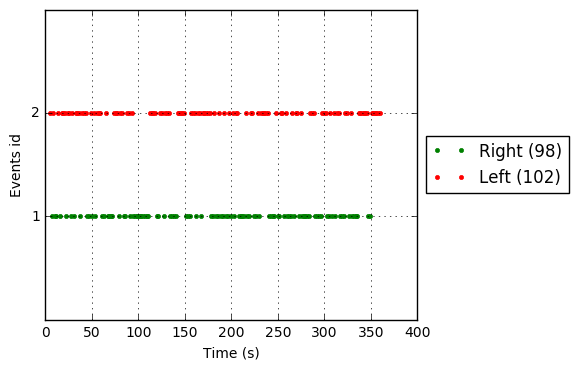

In [3]:
events = mne.find_events(raw)

event_id = {'Right': 1, 'Left': 2} # We define a name for each of our two conditions
color = {1: 'green', 2: 'red'} # And we also define a color that will be used to plot them

mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp, color=color,
                    event_id=event_id); # Now let's plot the events we found

In [4]:
tmin, tmax = -0.2, 0.5 # Here we define the amount of time we want to keep before (tmin) and after (tmax) the event.
                       # Thus, we will split our signal into 0.7s chunks.
    
baseline = (None, 0.0) # When epoching, we often want to use some kind of baseline correction. Here, we define that our baseline
                       # starts at the beginning of the epoch and goes until the stimulus occurence (t=0)
    
reject = {'mag': 4e-12} # The Epochs() function allows to automatically reject events in which one or more channels exceeds a
                        # threshold value. We can set different values for different types of channels (mag, grad, eeg etc...).
                        # This is useful because even a meticulous pre-processing may leave some noisy segments in the data, and
                        # this method only rejects the contaminated trials while keeping the others intact.
            
picks = mne.pick_types(raw.info, meg='mag', eeg=False, eog=False) # We choose to analyse only the magnetometers ('mag')

epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin,
                    tmax=tmax, baseline=baseline, reject=reject, picks=picks) # This function splits the signal into epochs that
                                                                             # can be accessed separately by calling epochs[condition]

epochs.drop_bad() # Here, we drop the epochs that were marked as bad using the "reject" parameter. 
                  # The dropped epochs will not be used for further analysis.

200 matching events found
0 projection items activated
Loading data for 200 events and 841 original time points ...
1 bad epochs dropped


<Epochs  |  n_events : 199 (all good), tmin : -0.2 (s), tmax : 0.5 (s), baseline : (None, 0.0), ~742 kB, data not loaded,
 'Left': 101, 'Right': 98>

### Plotting evoked data
Now, we can try to see if there is a difference between the evoked activity in our two conditions.

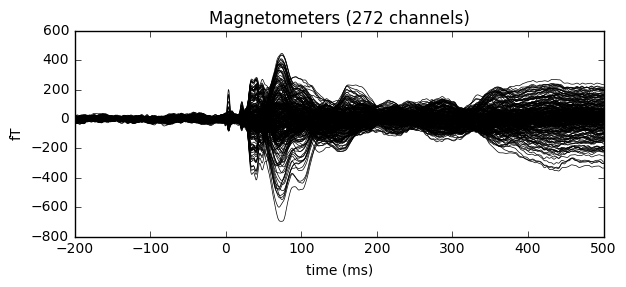

In [5]:
evoked = epochs.average() # The function average() creates an Evoked MNE object, which is the average of all the epochs.


evoked.plot(); # First, we can make a "butterfly" view of the evoked activity (across both conditions)

We clearly see a response that is phase-locked to the stimulus. Let's look at the topographic distribution of this evoked activity.

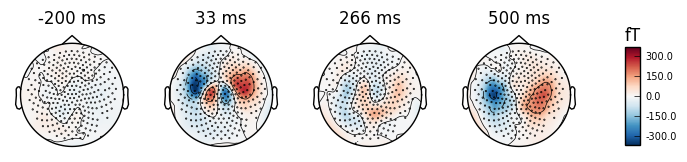

In [6]:
evoked.plot_topomap();

Look at the topography at 33ms. We can visually identify at least two generators. Are they somehow link to our experimental conditions ? Let's display them separately to confirm !

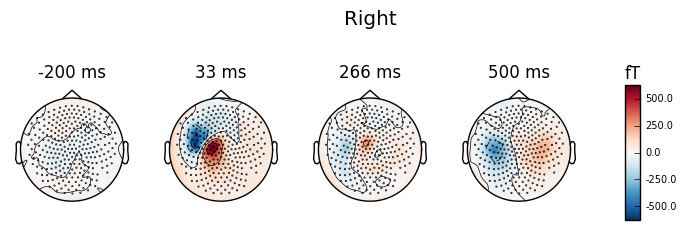

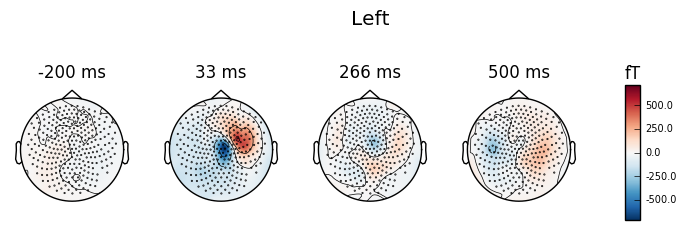

In [7]:
epochs['Right'].average().plot_topomap(title='Right');
epochs['Left'].average().plot_topomap(title='Left');

Looks like it ! That makes sense because we know that a stimulation of the right hand will induce activity in the left sensorimotor cortices, and conversely.

Now, we could also plot the Event-Related Field (ERF), to compare the two conditions across time.

In [8]:
# First, we have to build a dict containing the two conditions in separate entries
conditions = ["Right", "Left"]
evoked_dict = dict()

# Now we run a loop that will collect and average epochs separately for each condition
for condition in conditions:
    evoked_dict[condition] = epochs[condition].average().filter(l_freq=None, h_freq=30, method='iir') # Note that we apply a
                        # low-pass filter to the data (after averaging). This is a common practice to visualize data efficiently.
                                                                                
print(evoked_dict)

Setting up low-pass filter at 30 Hz
Setting up low-pass filter at 30 Hz
{'Right': <Evoked  |  comment : 'Right', kind : average, time : [-0.200000, 0.500000], n_epochs : 98, n_channels x n_times : 298 x 841, ~2.6 MB>, 'Left': <Evoked  |  comment : 'Left', kind : average, time : [-0.200000, 0.500000], n_epochs : 101, n_channels x n_times : 298 x 841, ~2.6 MB>}


We can now plot an ERF of each condition !

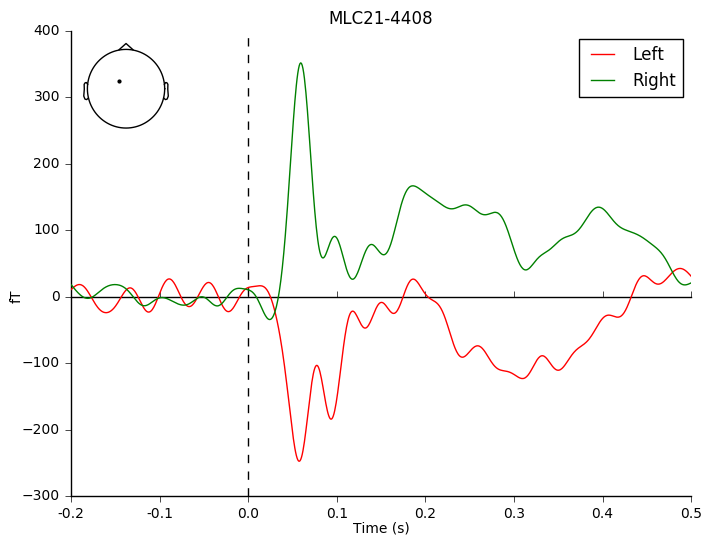

In [9]:
pick = epochs.ch_names.index('MLC21-4408') # I choose this sensor since it is just above sensorimotor areas.
colors = dict(Right='green', Left='red')
mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors);

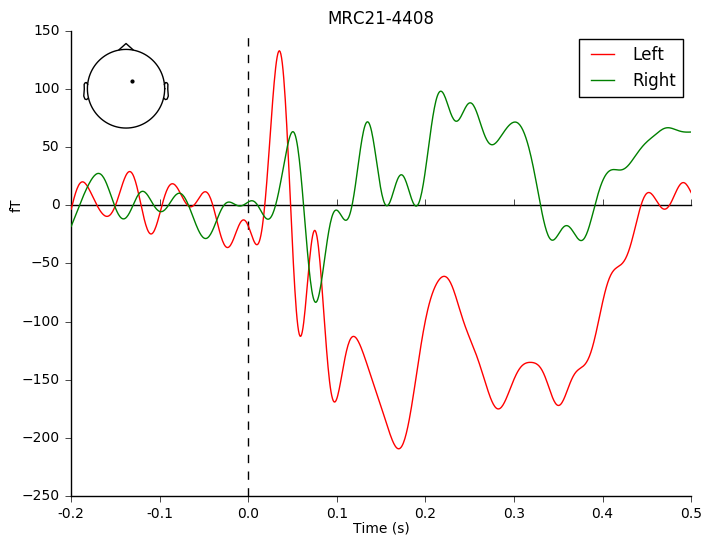

In [10]:
# Let's do the same for the same channel but in the other hemisphere
pick = epochs.ch_names.index('MRC21-4408')
colors = dict(Right='green', Left='red')

mne.viz.plot_compare_evokeds(evoked_dict, picks=pick, colors=colors);

The activity looked like it is reversed ! Again, this is exactly what we expected.

### Plotting spectral (PSD) data
Now that we did a quick overlook on the evoked activity, we should also perform some kind of spectral analysis.
Quantifying Power Spectrum Densities (PSD) in various frequency bands can inform us about the power distribution of cannonical oscillations. Alternatively, by using Time-Frequency Maps (TF maps) we can distinguish between evoked (phase-locked to the stimuli) and induced (not phase-locked) activity, which may behave differently.

Loading data for 199 events and 841 original time points ...


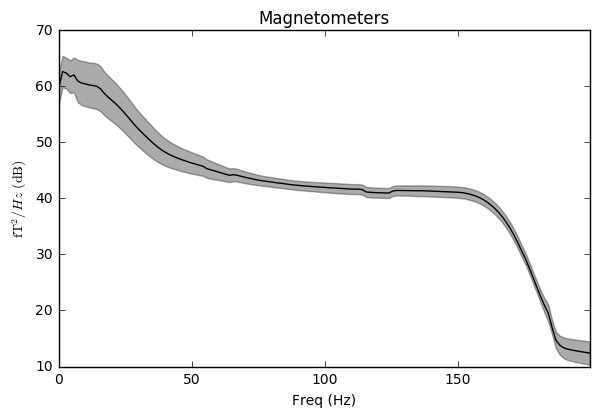

In [11]:
epochs.plot_psd(fmax=200); # First, let's have a look to the whole power spectrum. This is not very informative in our case 
                           # but it can help you to understand how your signal is structured (1/f, cut-off frequency etc...)

Loading data for 98 events and 841 original time points ...


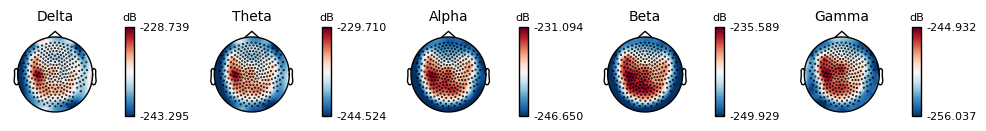

Loading data for 101 events and 841 original time points ...


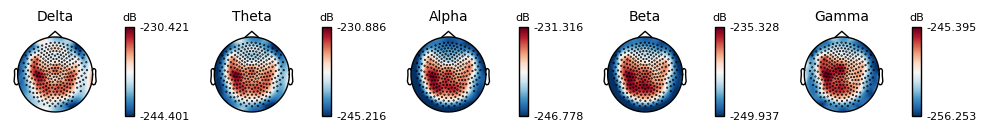

In [12]:
epochs['Right'].plot_psd_topomap(); # You can also plot the topographies of frequency bands.
epochs['Left'].plot_psd_topomap();  # Let's compare both conditions !

Meh, we don't see anything really convincing... Maybe a more lateralised activity in the 'Right' condition ?
Let's explore the TF representation.

Loading data for 199 events and 841 original time points ...
Applying baseline correction (mode: logratio)


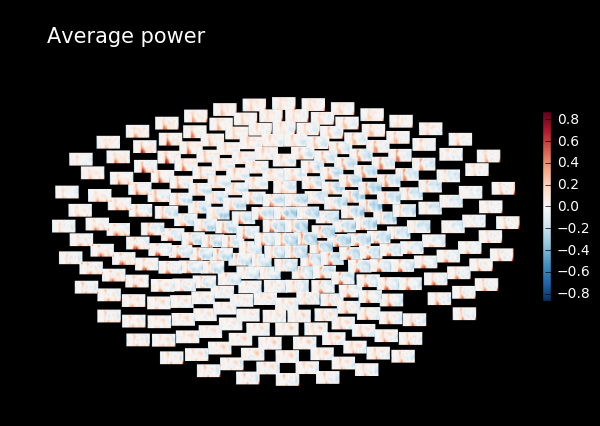

In [13]:
freqs = np.logspace(*np.log10([6, 35]), num=12) # Define the frequency range (i.e. frequential definition)
n_cycles = freqs / 4.  # Different number of cycle per frequency (i.e. temporal definition)

power, itc = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=True, decim=3, n_jobs=1)

power.plot_topo(baseline=baseline, mode='logratio', title='Average power', picks=None); # Plot the TF maps for each sensor

Since we want to compare Left and Right stimulations, we should build a TF map for each condition.

In [17]:
power_right, itc_right = mne.time_frequency.tfr_morlet(epochs['Right'], freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=True, decim=3, n_jobs=1)
power_left, itc_left = mne.time_frequency.tfr_morlet(epochs['Left'], freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=True, decim=3, n_jobs=1)
# Note that here we only selected epochs from the Left or Right conditions.

Loading data for 98 events and 841 original time points ...
Loading data for 101 events and 841 original time points ...


Applying baseline correction (mode: logratio)


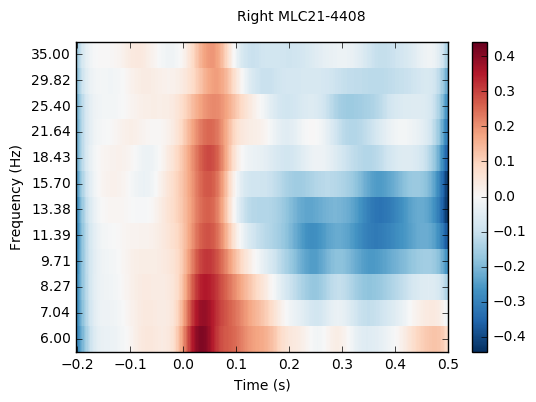

Applying baseline correction (mode: logratio)


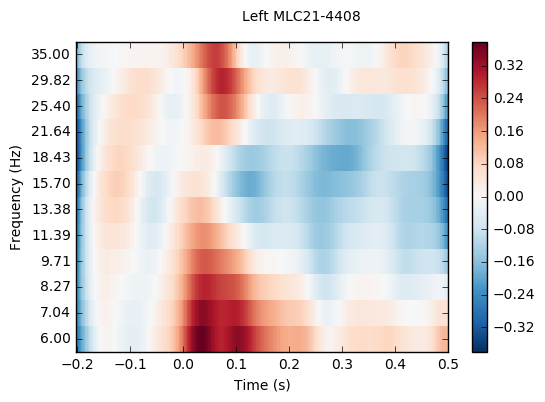

In [20]:
pick = power.ch_names.index('MLC21-4408')
power_right.plot([pick], baseline=baseline, mode='logratio', title='Right ' + power.ch_names[pick]);
power_left.plot([pick], baseline=baseline, mode='logratio', title='Left ' + power.ch_names[pick]);

Applying baseline correction (mode: logratio)


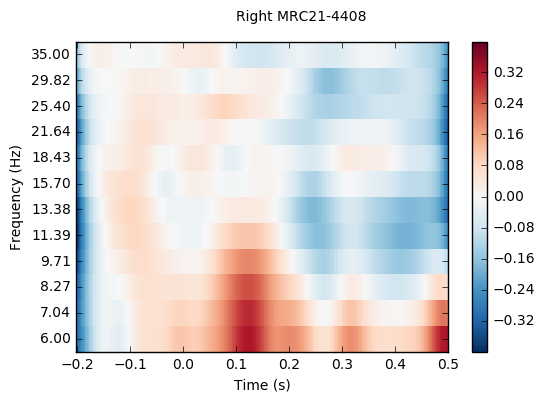

Applying baseline correction (mode: logratio)


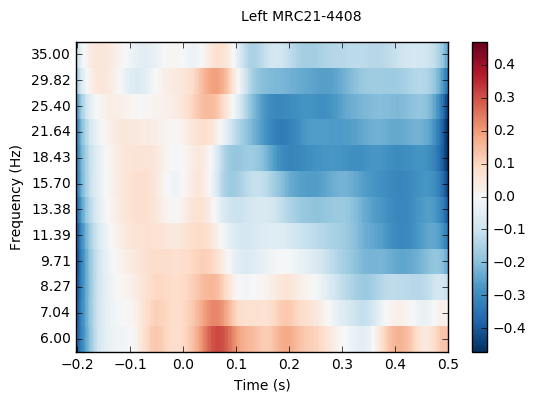

In [21]:
pick = power.ch_names.index('MRC21-4408')
power_right.plot([pick], baseline=baseline, mode='logratio', title='Right ' + power.ch_names[pick]);
power_left.plot([pick], baseline=baseline, mode='logratio', title='Left ' + power.ch_names[pick]);